In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
from itertools import chain
import sklearn.model_selection as skl
from random import sample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-04-18 09:16:11.154868: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 09:16:15.222284: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-18 09:16:26.776836: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 09:16:37.401465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

pd.set_option('display.max_columns', None)
all_xray_df.head()
print(len(all_image_paths))


Scans found: 24999 , Total Headers 112120
24999


In [3]:
# Check the count of NaN values in the 'path' column
print(all_xray_df['path'].isnull().sum())

# Drop NaN values from the 'path' column and assign the result back to all_xray_df
all_xray_df = all_xray_df.dropna(subset=['path'])

# Verify that there are no NaN values in the 'path' column after dropping
print(all_xray_df['path'].isnull().sum())


87121
0


In [8]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x)>0]
print(all_labels)

for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,data/images/00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,data/images/00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,data/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,data/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,data/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
all_xray_df[all_xray_df['pneumonia_class']== 'Positive']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN,data/images/00000013_010.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Positive
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,0.168,NaN,data/images/00000032_012.png,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,0.168,NaN,data/images/00000056_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Positive
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,0.139,NaN,data/images/00000061_012.png,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Positive
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN,data/images/00000061_015.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697,00006490_005.png,Edema|Infiltration|Pneumonia,5,6490,43,F,AP,2500,2048,0.168,0.168,NaN,data/images_02/00006490_005.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
24698,00006490_006.png,Pneumonia,6,6490,43,F,AP,2500,2048,0.168,0.168,NaN,data/images_02/00006490_006.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
24831,00006519_015.png,Edema|Pneumonia,15,6519,59,M,AP,2500,2048,0.168,0.168,NaN,data/images_02/00006519_015.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
24832,00006519_016.png,Edema|Pneumonia,16,6519,59,M,AP,2500,2048,0.168,0.168,NaN,data/images_02/00006519_016.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive


In [10]:
def create_splits(df_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data=skl.train_test_split(df_name,
                                              test_size=0.2,
                                             stratify=df_name['Pneumonia'])
    
    #balance train_data
    p_ind=train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
    n_ind=train_data[train_data['pneumonia_class']=='Negative'].index.tolist()
    n_sample = sample(n_ind,len(p_ind))
    train_data=train_data.loc[p_ind+n_sample]
    
    """balance val_data.  In the clinical setting where this algorithm will be deployed, 
    patients are being x-rayed based on their clinical symptoms that make Pneumonia 
    highly likely.  The prevalence of Pneumonia is about 20% of those who are x-rayed."""
    
    vp_ind=val_data[val_data['pneumonia_class']=='Positive'].index.tolist()
    vn_ind=val_data[val_data['pneumonia_class']=='Negative'].index.tolist()
    vn_sample = sample(vn_ind,4*len(vp_ind))
    val_data=val_data.loc[vp_ind+vn_sample]
    
    return train_data, val_data

In [11]:
train_data, val_data = create_splits(all_xray_df)
print((train_data['pneumonia_class']=='Positive').value_counts())
(val_data['pneumonia_class']=='Negative').value_counts()
train_data['Patient Gender'].value_counts()

pneumonia_class
True     230
False    230
Name: count, dtype: int64


Patient Gender
M    253
F    207
Name: count, dtype: int64

In [12]:
val_data['Patient Gender'].value_counts()

Patient Gender
M    159
F    131
Name: count, dtype: int64

In [13]:
def my_image_augmentation_train():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_train_idg = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      height_shift_range = 0.1,
                                      width_shift_range = 0.1,
                                      rotation_range = 15,
                                      shear_range = 0.1,
                                      zoom_range = 0.1, 
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                     )
    return my_train_idg

def my_image_augmentation_val():
    my_val_idg = ImageDataGenerator(rescale = 1./255.,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True
                                    )
    return my_val_idg


def make_train_gen(my_train_idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 16
                                          )

    return train_gen


def make_val_gen(my_val_idg, val_df):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224,224), 
                                              batch_size = 32,
                                              shuffle=False
                                             ) 
    
    return val_gen

In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(my_image_augmentation_val(),val_data)


Found 290 validated image filenames belonging to 2 classes.


Found 460 validated image filenames belonging to 2 classes.
Batch Mean: -4.034464e-08 Batch Std: 0.99999565


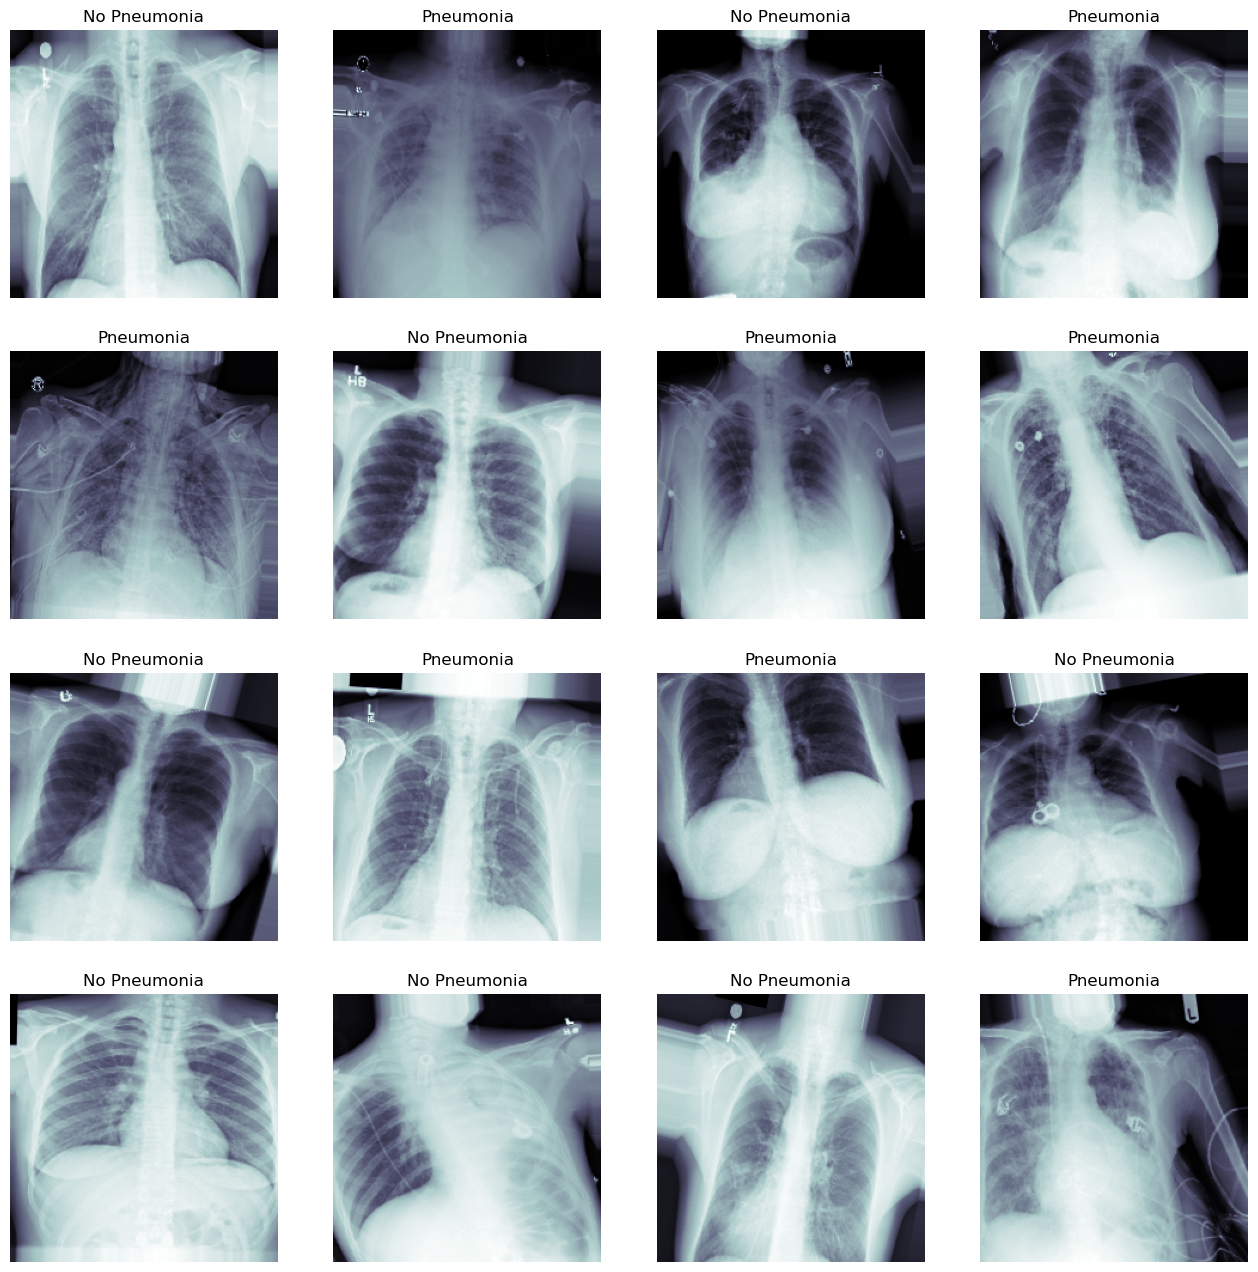

In [14]:
###### May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_idg = my_image_augmentation_train()
train_gen = make_train_gen(train_idg, train_data)

t_x, t_y = next(train_gen)
print("Batch Mean: " + str(t_x.mean()) + " Batch Std: " + str(t_x.std()))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')